# Bi-directional seq2seq using GloVe embeddings, not working yet. 

In [1]:
from attention import AttentionLayer
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
import warnings
import matplotlib.pyplot as plt
%matplotlib
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Using matplotlib backend: TkAgg


In [2]:
data=pd.read_csv("..\\Data\\model_training\\100000_samples_Reviews.csv", nrows=9000)
# data=pd.read_csv('../../BetaLab-meeting-minutes/Reviews.csv', nrows=50000)
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na rows

In [3]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [4]:
# data=data.rename(columns = {'article': 'Text', 'title': 'Summary'})
data.head()

,Text,Summary
0,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,Good Quality Dog Food
1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...","""Delight"" says it all"
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,Cough Medicine
4,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",Great taffy


In [5]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [6]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [7]:
for i in range(2):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print()

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: good quality dog food 

Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: not as advertised 



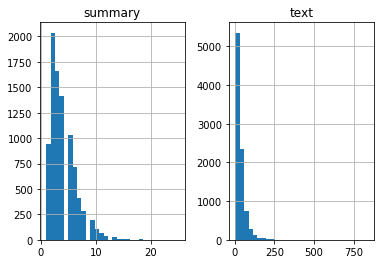

In [8]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [12]:
max_len_text=80
max_len_summary=10

In [13]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [14]:
# Apply start of sentence/ end of sentence tokens to summary, used for 
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,sostok delight says it all eostok
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok
...,...,...
8198,paris bistro favorite flavor senseo nice mild flavor well late afternoon pickemup enjoyed senseo europe years visits waited till finally available get regular douwe egberts coffee local european d...,sostok love senseo eostok
8199,coffee smell taste great recommend senseo vienna still packages paris nobody wanna drink guess throw away,sostok smells and tastes funny eostok
8200,tried brands french vanilla coffee best highly recommend,sostok best of the best eostok
8201,nice flavor great aroma brewing everyone always jealous brew work,sostok nice quick cup of coffee eostok


# Version 1: Preprocessing

# Use Version 2: Preprocessing,
uses a smaller VOCAB_SIZE instead of finding the "right" number of words.

trains using all data instead of train/validation. Gives lower loss results.

In [15]:
# np.array(df['text']),np.array(df['summary']),test_size=0.2
VOCAB_SIZE=999

# Text
text_tokenizer = Tokenizer(num_words=VOCAB_SIZE) # for the vocabulary
text_tokenizer.fit_on_texts(list(df.text))
text_sequences=text_tokenizer.texts_to_sequences(list(df.text))
text_word_index=text_tokenizer.word_index

text_word_index_vocab={}
counter = 0
for word in text_word_index.keys():
    if text_word_index[word] == 0:
        print("found 0!")
        break
    if text_word_index[word] > VOCAB_SIZE:
        continue
    else:
        text_word_index_vocab[word] = text_word_index[word]
        counter += 1
print(counter)

# Summaries
sum_tokenizer = Tokenizer(num_words=VOCAB_SIZE) # for the vocabulary
sum_tokenizer.fit_on_texts(list(df.summary))
sum_word_index=sum_tokenizer.word_index

sum_word_index_vocab={}
counter = 0
for word in sum_word_index.keys():
    if sum_word_index[word] == 0:
        print("found 0!")
        break
    if sum_word_index[word] > VOCAB_SIZE:
        continue
    else:
        sum_word_index_vocab[word] = sum_word_index[word]
        counter += 1
print(counter)
# should produce counter=VOCAB_SIZE=299 twice. 

999
999


In [16]:
from itertools import islice
dict(islice(sum_word_index_vocab.items(), 10))

{'sostok': 1,
 'eostok': 2,
 'great': 3,
 'good': 4,
 'the': 5,
 'for': 6,
 'not': 7,
 'best': 8,
 'and': 9,
 'it': 10}

## Pad sequences

In [17]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN=20
text_sequences=text_tokenizer.texts_to_sequences(list(df.text))
sum_sequences=sum_tokenizer.texts_to_sequences(list(df.summary))

pad_text_sequences = pad_sequences(text_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
pad_sum_sequences = pad_sequences(sum_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
print(len(text_sequences[1]), len(pad_text_sequences[1]))
print(pad_text_sequences.shape)
pad_text_sequences

9 20
(8203, 20)


array([[ 40, 211, 412, ...,   0,   0,   0],
       [  7, 205, 943, ...,   0,   0,   0],
       [230, 185, 474, ...,   0,   0,   0],
       ...,
       [ 23, 151, 440, ...,   0,   0,   0],
       [ 61,   6,   3, ...,   0,   0,   0],
       [298, 179,  10, ...,   4,  17, 225]])

## GloVe embeddings

In [22]:
import os
glove_dir='..\\Data\\word_embeddings'
glove_dimension=200
embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.'+str(glove_dimension)+'d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
from itertools import islice
list(islice(embeddings_index.items(), 1))

[('the',
  array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
          3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
          1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
         -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
          4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
          7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
          1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
         -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
         -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
          6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
         -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
          8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
          1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
          1.4379e-01, -1.2325

In [24]:
def embedding_matrix_creater(embedding_dimention, word_index): 
    """
    Uses GloVe as a global word embedding. 
    
    embedding_dimention: usually in the title of glove.6D.'embedding_dimention', in this notebook use 50. 
    word_index: the input word embeddings
    
    returns: a local embedding matrix, to be input as weights [embedding] for the constructor
        for keras' Embedding object. 
    """
    local_embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word) # from cell above, from glove.
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            local_embedding_matrix[i] = embedding_vector
    return local_embedding_matrix

In [26]:
from tensorflow.keras.layers import Embedding
text_embedding_matrix = embedding_matrix_creater(glove_dimension, 
        word_index=text_word_index_vocab)
print(text_embedding_matrix.shape)

sum_embedding_matrix = embedding_matrix_creater(glove_dimension, 
        word_index=sum_word_index_vocab)
print(sum_embedding_matrix.shape)

encoder_embedding_layer = Embedding(input_dim = text_embedding_matrix.shape[0], # vocab size
                                    output_dim = text_embedding_matrix.shape[1], # embedding dimension
                                    input_length = MAX_LEN, # sequence length
                                    weights = [text_embedding_matrix],
                                    trainable = False) # False because these embeddings have already been trained. 

decoder_embedding_layer = Embedding(input_dim = sum_embedding_matrix.shape[0],
                                    output_dim = sum_embedding_matrix.shape[1],
                                    input_length = MAX_LEN,
                                    weights = [sum_embedding_matrix],
                                    trainable = False) # False because these embeddings have already been trained. 

(1000, 200)
(1000, 200)


## Base model

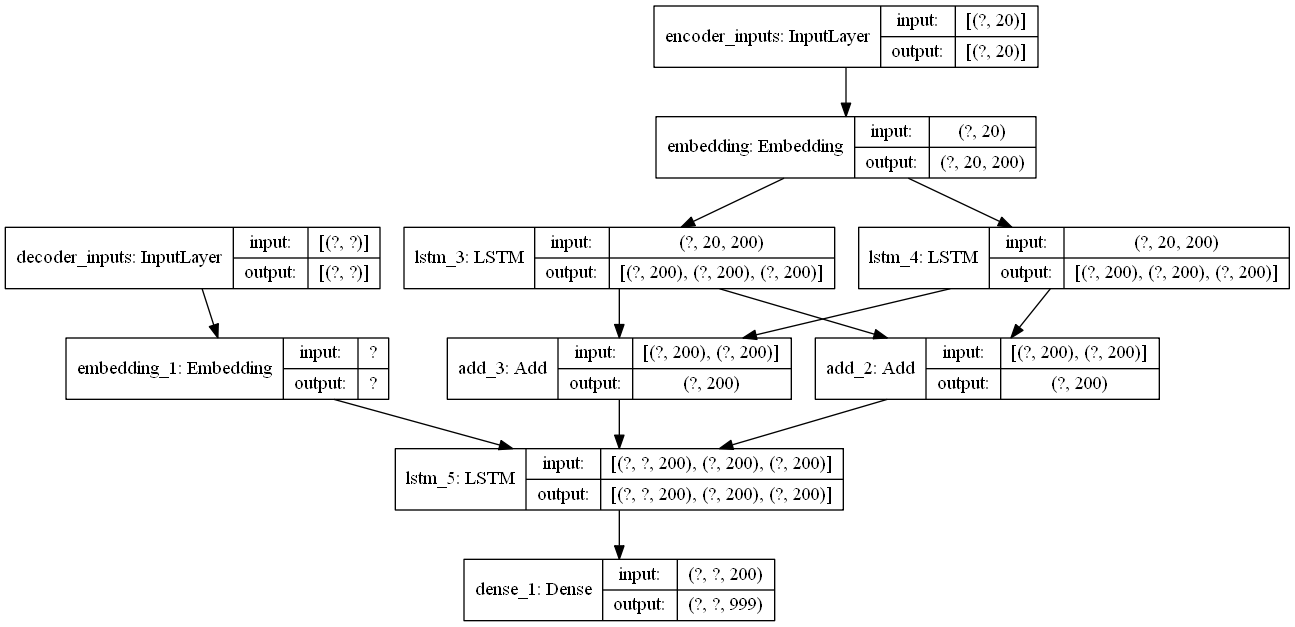

In [42]:
"""
Bidirectional LSTM: Others Inspired Encoder-Decoder-seq2seq
"""
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout,  Dense, Activation,Add, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
# MAX_LEN = 20
HIDDEN_UNITS=200
encoder_inputs = Input(shape=(MAX_LEN,), name='encoder_inputs')
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_states = [final_h, final_c]

"""
decoder
"""
decoder_inputs = Input(shape=(None,), name='decoder_inputs') # may be either (max_len_summary,) or (None,)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
decoder_dense = Dense(sum_embedding_matrix.shape[0]-1, activation='linear') # sum_embedding_matrix.shape[0] -1 = VOCAB_SIZE
decoder_outputs = decoder_dense(decoder_outputs)

model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)
# plot the model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Compile + Train Model

In [43]:
# """
# Chatbot Inspired Encoder-Decoder-seq2seq
# """
# HIDDEN_UNITS=300
# from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout,Dense, Activation,Add, Concatenate, TimeDistributed, Bidirectional
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping
# encoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
# encoder_embedding = encoder_embedding_layer(encoder_inputs)
# encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
# encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

# decoder_inputs = Input(shape=(None, ), dtype='int32',)
# decoder_embedding = decoder_embedding_layer(decoder_inputs)
# decoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True, return_sequences=True)
# decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

# outputs = (Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)
# model = Model([encoder_inputs, decoder_inputs], outputs)
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# import tensorflow as tf
# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [44]:

# """
# Simple LSTM Encoder-Decoder-seq2seq
# """
# # encoder
# encoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
# encoder_embedding = encoder_embedding_layer(encoder_inputs)
# encoder_LSTM = LSTM(HIDDEN_UNITS)(encoder_embedding)
# # decoder
# decoder_inputs = Input(shape=(MAX_LEN, ))
# decoder_embedding = decoder_embedding_layer(decoder_inputs)
# decoder_LSTM = LSTM(200)(decoder_embedding)
# # merge
# merge_layer = concatenate([encoder_LSTM, decoder_LSTM])
# decoder_outputs = Dense(units=VOCAB_SIZE+1, activation="softmax")(merge_layer) # SUM_VOCAB_SIZE, sum_embedding_matrix.shape[1]

# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# model.summary()

# NEW

In [45]:
num_samples = len(pad_sum_sequences)
decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="int32")

In [46]:
for i, seqs in enumerate(pad_sum_sequences):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data[i][j][seq] = 1

In [47]:
from sklearn.model_selection import train_test_split
art_train, art_test, sum_train, sum_test = train_test_split(pad_text_sequences, pad_sum_sequences, test_size=0.2)
# X_train, X_test, y_train, y_test

In [48]:
train_num = art_train.shape[0]
train_num

6562

In [49]:
target_train = decoder_output_data[:train_num]
target_test = decoder_output_data[train_num:]
target_train.shape

(6562, 20, 999)

In [50]:
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(lr=0.01, clipnorm=1.)
model.compile(loss='mse', optimizer=rmsprop, metrics=["accuracy"])
history = model.fit([art_train, sum_train], 
                     target_train, 
                     epochs=1, # will implement early stopping, see callbacks. 
                     batch_size=128,
#                      callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
                     validation_data=([art_test, sum_test], target_test))

Train on 6562 samples, validate on 1641 samples
6562/6562 [==============================] - 20s 3ms/sample - loss: 0.0308 - accuracy: 0.6615 - val_loss: 3.4917e-04 - val_accuracy: 0.7432


## Inference Model

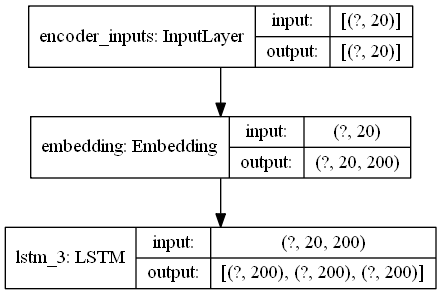

In [51]:
# define encoder inference model
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
tf.keras.utils.plot_model(encoder_model, to_file='encoder_model_bi.png', show_shapes=True)

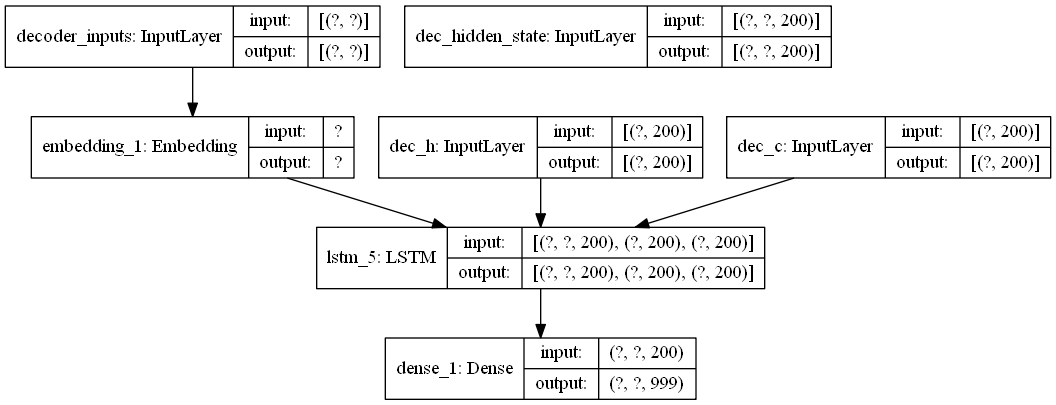

In [52]:
# define decoder inference model
decoder_state_input_h = Input(shape=(HIDDEN_UNITS,), name='dec_h')
decoder_state_input_c = Input(shape=(HIDDEN_UNITS,), name='dec_c')
decoder_hidden_state_input = Input(shape=(None,HIDDEN_UNITS), name='dec_hidden_state') # encoder output

decoder_outputs, state_h, state_c = decoder_LSTM(decoder_embedding, 
                                initial_state=[decoder_state_input_h, decoder_state_input_c])
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h,decoder_state_input_c], 
    [decoder_outputs] + [state_h, state_c])
tf.keras.utils.plot_model(decoder_model, to_file='decoder_model_bi.png', show_shapes=True)

In [53]:
reverse_target_word_index=sum_tokenizer.index_word
reverse_source_word_index=text_tokenizer.index_word 
target_word_index=sum_tokenizer.word_index

In [54]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [55]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    print('input_seq:', input_seq)
    print('input_seq.shape:', input_seq.shape)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    e_out=e_out.reshape(1,1,HIDDEN_UNITS)
    print('e_out:', e_out[0][0][0])
    print('e_h:', e_h[0][0])
    print('e_c:', e_c[0][0])
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Chose the 'start' word as the first word of the target sequence
    target_seq[0,0] = target_word_index['sostok']
    # works fine
    print('target_seq.shape:', target_seq.shape)
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        print('e_out.shape:', e_out.shape)
        print('e_h.shape:', e_h.shape)
        print('e_c.shape:', e_c.shape)
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
    
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         print(sampled_token_index)
#         if sampled_token_index != 0: # loops here too many times, shouldn't have an index of 0, but consistently does. 
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (MAX_LEN-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [56]:
for i in range(0,20):
    print("Review:",seq2text(art_train[i]))
    print("Original summary:",seq2summary(sum_train[i]))
    print()
    print("Predicted summary:",decode_sequence(art_train[i].reshape(1,MAX_LEN)))
    print("________________________________________________________")
    print("\n")
    # Key error 0 means that the decoder predicts the sostok (start of sentence token),
    # which should never happen. It may be because it is bi-directional thinking that
    # the start of a sentence needs to use a sostok. 

Review: coffee flavor better bought try something two probably get taste also bit pricey get 
Original summary: it ok 

input_seq: [[  4   6  26  40  30  88  70 241  13   5  27  63 892  13   0   0   0   0
    0   0]]
input_seq.shape: (1, 20)
e_out: -0.268943
e_h: -0.268943
e_c: -0.4310286
target_seq.shape: (1, 1)
e_out.shape: (1, 1, 200)
e_h.shape: (1, 200)
e_c.shape: (1, 200)


KeyError: 0